# Network construction & Community detection--Twitter data

### We are given the data from tweeter, recording users' ID and the time and location when they post anything. Our basic idea is to construct a network where we observe the relation among places by analyzing people's activities near each location, trying to detect grouping communities and distinguish weak links from strong ones.

### Step 1,  load the data from twitter and categorize it by weekdays/weekend

In [1]:
%pwd

u'/Users/CQ/Documents/Project1'

In [1]:
from __future__ import print_function
import matplotlib.pyplot as plt
import networkx as nx #library supporting networks
#make sure plots are embedded into the notebook
%pylab inline
import scipy
import numpy as np
import pandas as pd
from datetime import datetime
import csv
import matplotlib
from mpl_toolkits import basemap
from descartes import PolygonPatch
from shapely.geometry.polygon import Polygon
from matplotlib import colors
from mpl_toolkits.basemap import shapefile as shp
import community #Louvain method
import operator
from datetime import timedelta, date
import time
from collections import Counter

Populating the interactive namespace from numpy and matplotlib


ImportError: cannot import name basemap

#### Some information about these files:
* zipsf is the shapefile of zip codes from all over the United States, provided by CUSP at NYU
* twitter_file is the main database here, recording all tweeting activities from *Nov.4th 2015 to Feb.12th 2016*
* USzipcode is the dataframe containing zipcodes in U.S. but there are some zipcodes missing, and we will only provide analysis based on the zipcodes we have here in the database
* NOTE: For the majority of missing zipcodes, personal experience tells me that those zipcodes are usually parks or forests, in other words, the places where postal service is not needed much

In [2]:
zipsf = shp.Reader('/Users/CQ/Documents/Project1/ManhattanStreetMap/cb_2014_us_zcta510_500k.shp')
zipsf_records = zipsf.records()
zipsf_shape = zipsf.shapeRecords()
twitter_file = pd.read_csv('/Users/CQ/Documents/Project1/2016_02_18_sintetic.csv')
USzipcode = pd.read_csv('/Users/CQ/Documents/Project1/USzipcode_XY.csv')

#### Convert time stamp into time format and then categorize our data into four different datasets:
1. All data, labeled  All days with **date_index 0**
2. Data from weekdays, labeled  Weekdays with **date_index 1**
3. Data from Saturdays, labeled  Saturdays with **date_index 2**
4. Data from Sundays, labeled  Sundays with **date_index 3**

In [3]:
TimeList = range(4)
TimeList[0] = [time.localtime(x) for x in twitter_file.timestamp]
TimeList[1] = [x for x in TimeList[0] if x.tm_wday < 5]
TimeList[2] = [x for x in TimeList[0] if x.tm_wday == 5]
TimeList[3] = [x for x in TimeList[0] if x.tm_wday == 6]
twitter_file.iloc[:,0] = TimeList[0]

twitter_file.columns = ['DateTime','Stamp','ZipCode','User','ID']
USzipcode.columns = ['ZipCode','lat','lon']

#### Change the columns' names as above, compute and filter the results, drop all zeros

In [4]:
def Clean_zipcode(dataset):
    zipcode_all = list(sorted(set(dataset.ZipCode)))
    zip_exist = [i for i in zipcode_all if i in USzipcode.ZipCode.values]
    return dataset[dataset.ZipCode.isin(zip_exist)]

In [5]:
Data = range(4)
for i in range(4):
    Data[i] = twitter_file[twitter_file.DateTime.isin(TimeList[i])]
    Data[i] = Clean_zipcode(Data[i])

### Step 2, construct a network with the probability, or equivalently, the weight of link(a,b) defined as
### $$link(a,b) = \Sigma_c\frac{t(c,a)*(t(c,b)-\delta(a,b))}{T*(t(c)-1)}$$
### where
* *t(c,a)* denotes the total number of tweets that user *c* has posted at location (in our case, zipcode) *a*
* $t(c) = \Sigma_a t(c,a)$
* $T = \Sigma_c t(c)$

In [6]:
def Normalized_weight(dataset):
    user = sort(dataset.User.unique())
    places = sort(dataset.ZipCode.unique())
    lu = len(user)
    lp = len(places)
    visit_frq = np.zeros((lu,lp))
    for i in range(lu):
        for j in range(lp):
            visit_frq[i,j] = len(dataset.loc[(dataset.User == user[i]) & (dataset.ZipCode == places[j])])
    data = pd.DataFrame(visit_frq, columns = places, index = user)
    return data

In [7]:
def Network_prob_build(dataset):
    graph = nx.DiGraph()
    places = [int(x[-5:]) for x in list(dataset.columns)[1:]]
    graph.add_nodes_from(places)
    T = sum(sum(dataset)[1:])
    tc = sum(dataset.iloc[:,1:], axis = 1)
    #TC = dict(zip(list(dataset.UserID), tc))
    ix_tc = tc > 1
    #the formula is provided above
    for a in places:
        ix_a = places.index(a)
        for b in places:
            ix_b = places.index(b)
            if ix_a != ix_b:
                w = dataset.iloc[:,ix_a+1][ix_tc] * dataset.iloc[:,ix_b+1][ix_tc] / (tc[ix_tc]-1)
                graph.add_edge(a,b, weight = sum(w)/T )
            else:
                w = dataset.iloc[:,ix_a+1][ix_tc] * (dataset.iloc[:,ix_b+1][ix_tc]-1) / (tc[ix_tc]-1)
                graph.add_edge(a,b, weight = sum(w)/T )
    return graph

#### Compared with our original network, here we label it as Network2

In [8]:
Net2 = range(4)
LABEL = ['All ','Week','Satur','Sun']

# WARNING: NEXT CELL MAY TAKE MORE THAN 22 HOURS TO RUN, WE'VE EXTRACTED THOSE DATA TO EXTERNAL FILES FOR FUTURE USAGE.

for i in range(4):
    Net2[i] = Normalized_weight(Data[i])
    Net2[i].to_csv('/Users/CQ/Documents/Project1/Network2 for '+LABEL[i]+'days.csv')

#### Now we load the data for further analysis

In [9]:
for i in range(4):
    Net2[i] = pd.read_csv('/Users/CQ/Documents/Project1/Network2/Network2 for '+LABEL[i]+'days.csv', index_col=)
    Net2[i].rename(columns={'Unnamed: 0':'UserID'}, inplace=True)

### Step 3, proceed to community detection, first construct the directed graphs based on the probabilistic methods, then plot the graphs

#### Convert these dataframes into directed graphs, and then perform combo partition and community plotting to see the results

In [10]:
Graph2 = range(4)
for i in range(4):
    Graph2[i] = Network_prob_build(Net2[i])

In [11]:
def NYCMapShape(x, fig, date_index = 0):
    #x is a dictionary (zip codes vs values
    if max([a-int(a) for a in x.values()])==0: #if dealing with categries
        cmap = matplotlib.cm.hsv(np.linspace(0,1,max(x.values())+2))
        mode = 1
    else:
        cmap = matplotlib.cm.hsv(np.linspace(0,1,128))
        mode = 2
        v2 = max(x.values())
        v1 = min(x.values())
        
    title = ['All Data','Weekdays', 'Saturdays', 'Sundays']
    ax = fig.add_subplot(221 + date_index)   #note this fig3 for potential code modification
    plt.title(title[date_index], fontweight="bold", size=15)
    for s in range(len(zipsf_records)):
        z = int(zipsf_records[s][1][-5:])
        if z in x.keys():        #if z is in our zipcode list
            k = x[z]             #then k is z's values
            if mode == 2:
                k = int((k-v1)/(v2-v1)*127.9999)
            c = cmap[k][0:3]
            shape = zipsf_shape[s]
            w = [(i[0],i[1]) for i in shape.shape.points]
            poly = Polygon(w)
            #plt.fill(x,y,color=my_cmap[s])
            ax.add_patch(PolygonPatch(poly, fc = c, ec = c, alpha = 0.6, zorder = 2))
    ax.axis('scaled')
    ax.legend()
    plt.subplots_adjust(wspace = 0,hspace = 0.1)

Start with Louvain method if curious but not necessary, next try combo algorithm with Inf, 2, and 4 communities parititions.
* We will run tests for graphs both with and without loop edges
* Please note that you may have to downgrade the version of package networkx from 1.11 to 1.9.1 in order to successfully plot the graph  (--week 3, March 3rd 2016)

In [12]:
import os
workfolder = '/Users/CQ/Documents/Project1/CommunityDetection'
os.chdir(workfolder)

In [13]:
#interface for running compiled combo over the network G given a maximal number of communities maxcom
def getComboPartition(G, maxcom):
    #save network in net format
    nodes={}
    nodenum={}
    i=0
    #create a dictionary transforming nodes to unique numbers
    for n in G.nodes():
        nodenum[n]=i
        nodes[i]=n
        i+=1
    f = open('combo/temp.net', 'w')
    f.write('*Arcs\n')
    for e in G.edges(data=True):
        f.write('{0} {1} {2}\n'.format(nodenum[e[0]],nodenum[e[1]],e[2]['weight']))
    f.close()
    #run combo
    command=workfolder+'/combo/comboCPP combo/temp.net'
    if maxcom<Inf:
        command=command+' {0}'.format(maxcom)  
    os.system(command)
    #read resulting partition
    f = open('combo/temp_comm_comboC++.txt', 'r')
    i=0
    partition={}
    for line in f:
        partition[nodes[i]]=int(line)
        i+=1
    return partition

#### Part A, Loop-edges are included
* Louvain method, labeled "**BestPart**"
* Combo method:
    * "infinite" for optimal result, labeled "**CPInf**"
    * "2" for two-communities partition, labeled "**CP2**"
    * "4" for four-communities partition, labeled "**CP4**"

In [14]:
CPInf, CP2, CP4 = range(4),range(4),range(4)
for i in range(4):
    CPInf[i] = getComboPartition(Graph2[i], Inf)
    CP2[i] = getComboPartition(Graph2[i], 2)
    CP4[i] = getComboPartition(Graph2[i], 4)

In [15]:
def modularity(G, partition):
    #compute network modularity according to the given partitioning
    nodes=G.nodes()
    #compute node weights and total network weight
    if G.is_directed():
        w1=G.out_degree(weight='weight')
        w2=G.in_degree(weight='weight')
        T=1.0*sum([e[2]['weight'] for e in G.edges(data=True)])
    else:
        w1=G.degree(weight='weight')
        w2=G.degree(weight='weight')
        T=1.0*sum([(1+(e[0]!=e[1]))*e[2]['weight'] for e in G.edges(data=True)])
    M=0.0 #start accumulating modularity score
    for a in nodes:
        for b in nodes:
            #if (G.is_directed())|(b>=a):
            if partition[a]==partition[b]: #if nodes belong to the same community
                    #get edge weight
                if G.has_edge(a,b):
                    e=G[a][b]['weight']
                else:
                    e=0
                M+=e/T-w1[a]*w2[b]/(T**2) #add modularity score for the considered edge 
    return M

In [16]:
def CommPartShape(fig, G, partition, date_index):
    '''This functin is for plotting geographical maps with 4 arguments:
    fig: for subplotting purpose mainly, usually not necessary
    G: the graph, does not have to be directed, for modularity computation
    partitin: self-explanatory, although it can be non-integers
    data_index: 0 denoting all data, and 1, 2, 3 for weekday, Saturday, Sunday
    '''
    if max([a-int(a) for a in partition.values()])==0:
        cmap = matplotlib.cm.hsv(np.linspace(0,1,max(partition.values())+2))
        mode = 1
    else:
        cmap = matplotlib.cm.cool(np.linspace(0,1,128))
        mode = 2
        v2 = log(max(partition.values()))
        v1 = log(min(partition.values()))
    title = ['All Data','Weekdays', 'Saturdays', 'Sundays']
    
    ClusterList = [ (j, partition.values().count(j)*1.0/len(partition)) for j in set(partition.values())]
    ClusterList.sort(key = operator.itemgetter(1), reverse = 1)
    ClusterRanking = [i[0] for i in ClusterList]
    
    ax = fig.add_subplot(221 + date_index)
    plt.title(title[date_index]+', modularity %f' % modularity(G,partition), fontweight="bold", size=15)
    for s in range(lzipsf):
        z = int(zipsf_records[s][1][-5:])
        if z in partition.keys():
            k = partition[z]
            if mode == 2:
                k = int((log(k)-v1)/(v2-v1)*127.9999)
            c = cmap[ClusterRanking.index(k)][0:3]
            shape = zipsf_shape[s]
            w = [(i[0],i[1]) for i in shape.shape.points]
            poly = Polygon(w)
            ax.add_patch(PolygonPatch(poly, fc = c, ec = c, alpha = 0.6, zorder = 2))
    ax.axis('scaled')
    ax.legend()
    plt.subplots_adjust(hspace = 0.1, wspace = 0)

/Users/CQ/anaconda/lib/python2.7/site-packages/matplotlib/axes/_axes.py:519: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


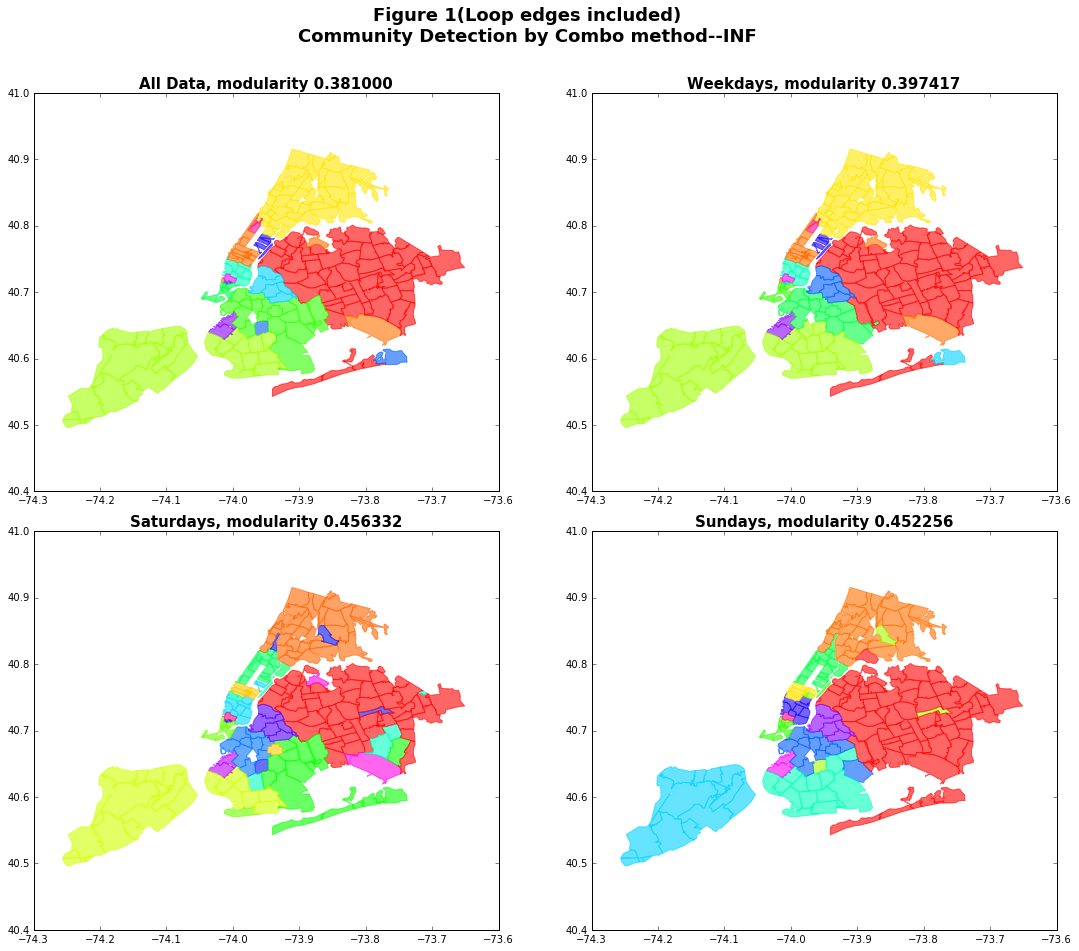

In [17]:
lzipsf = len(zipsf_shape)
fig1 = plt.figure(num = 1, figsize = (20,15))
plt.suptitle('Figure 1(Loop edges included)\nCommunity Detection by Combo method--INF', fontweight="bold", size=18)
for i in range(4):
    CommPartShape(fig1, Graph2[i], CPInf[i],i)

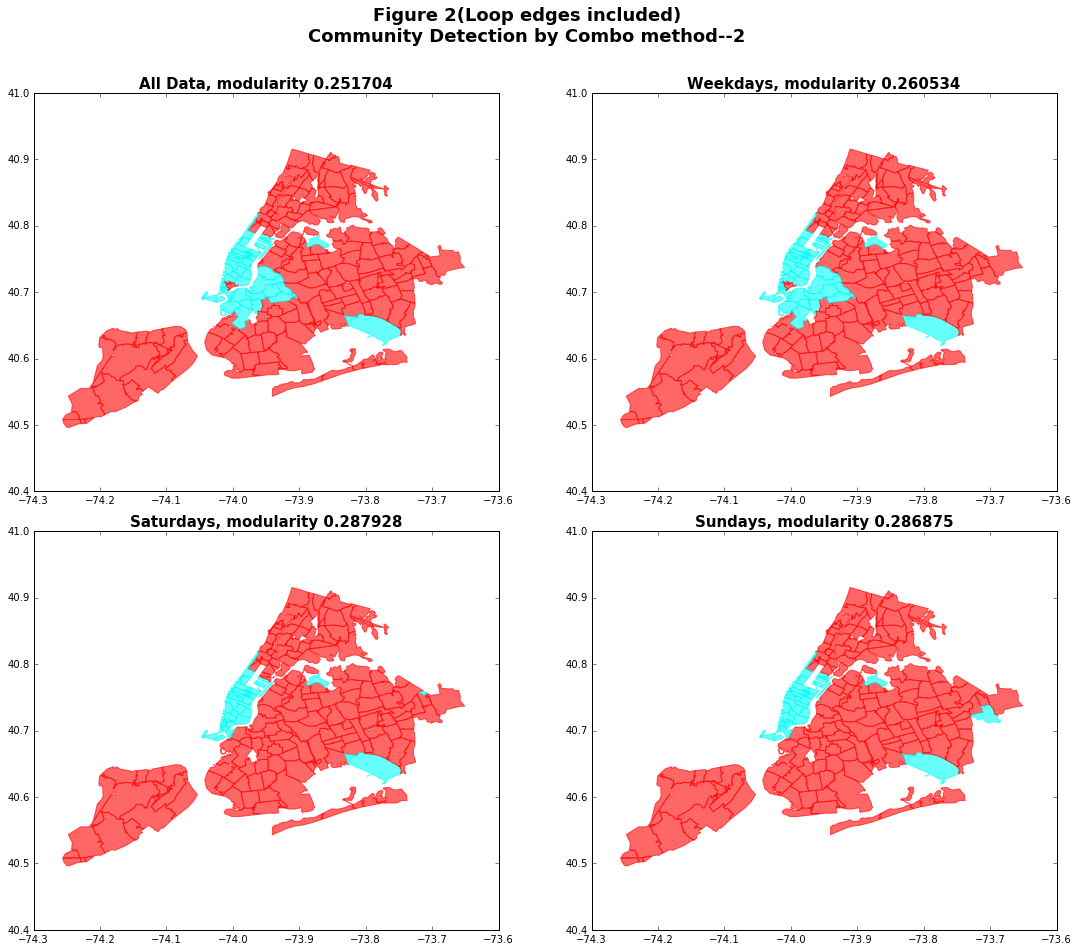

In [18]:
fig2 = plt.figure(num = 2, figsize = (20,15))
plt.suptitle('Figure 2(Loop edges included)\nCommunity Detection by Combo method--2', fontweight="bold", size=18)
for i in range(4):
    CommPartShape(fig2, Graph2[i], CP2[i],i)

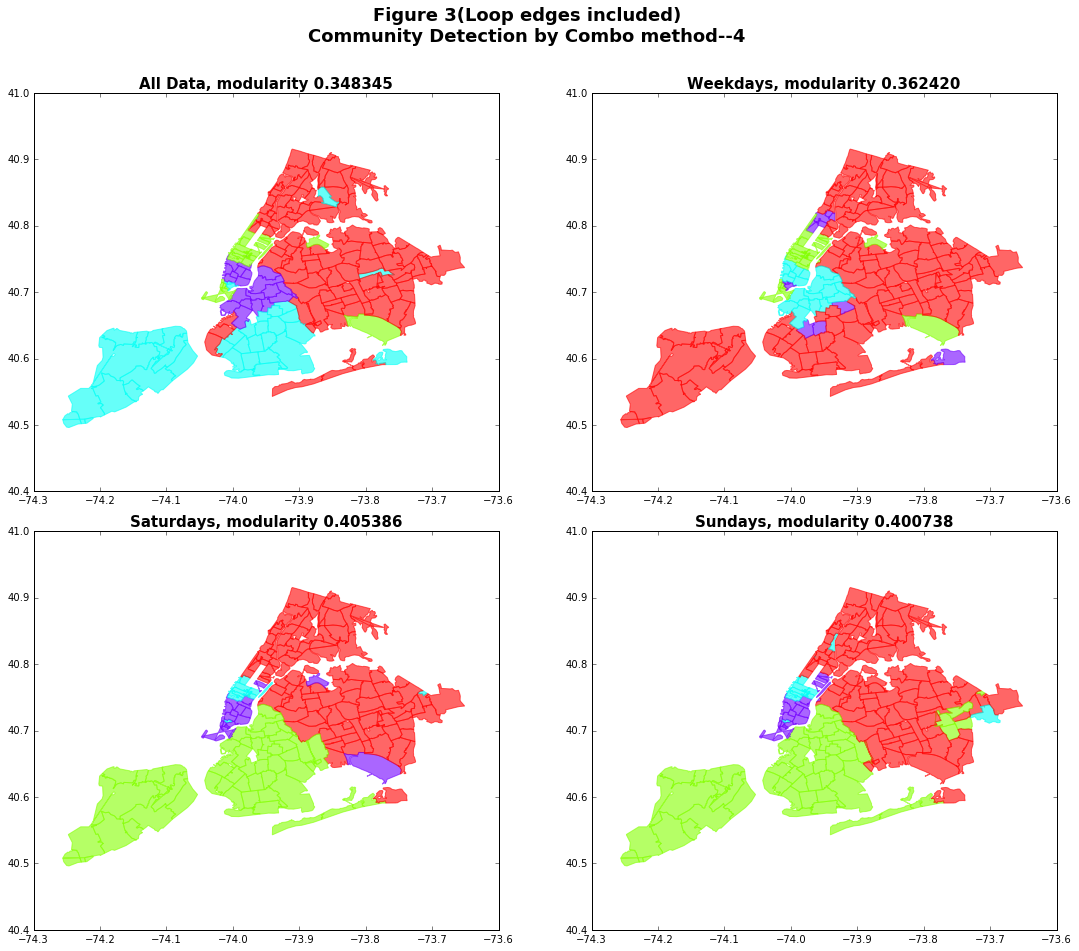

In [19]:
fig3 = plt.figure(num = 3, figsize = (20,15))
plt.suptitle('Figure 3(Loop edges included)\nCommunity Detection by Combo method--4', fontweight="bold", size=18)
for i in range(4):
    CommPartShape(fig3, Graph2[i], CP4[i],i)

### Part B, Loop-edges are NOT included, similarly draw graphs and calculate modularities respectively, given:
* Louvain method, labeled "**NLEBestPart**"
* Combo method:
    * "infinite" for optimal result, labeled "**NLECCPInf**"
    * "2" for two-communities partition, labeled "**NLECP2**"
    * "4" for four-communities partition, labeled "**NLECP4**"

In [20]:
#remove loop edges from a network
def remove_loops(G):
    if G.is_directed():
        NLEG = nx.DiGraph()
    else:
        NLEG = nx.Graph()
    NLEG.add_nodes_from(G.nodes())
    
    for e in G.edges():
        NLEG.add_edge(e[0],e[1], weight = G[e[0]][e[1]]['weight'])
            
    for n in NLEG.nodes():
        if NLEG.has_edge(n,n):
            NLEG.remove_edge(n,n)
    return NLEG

In [21]:
NLGraph2, NLCPInf, NLCP2, NLCP4 = range(4), range(4), range(4), range(4)
for i in range(4):
    NLGraph2[i] = remove_loops(Graph2[i])  
    NLCPInf[i] = getComboPartition(NLGraph2[i], Inf)
    NLCP2[i] = getComboPartition(NLGraph2[i], 2)
    NLCP4[i] = getComboPartition(NLGraph2[i], 4)

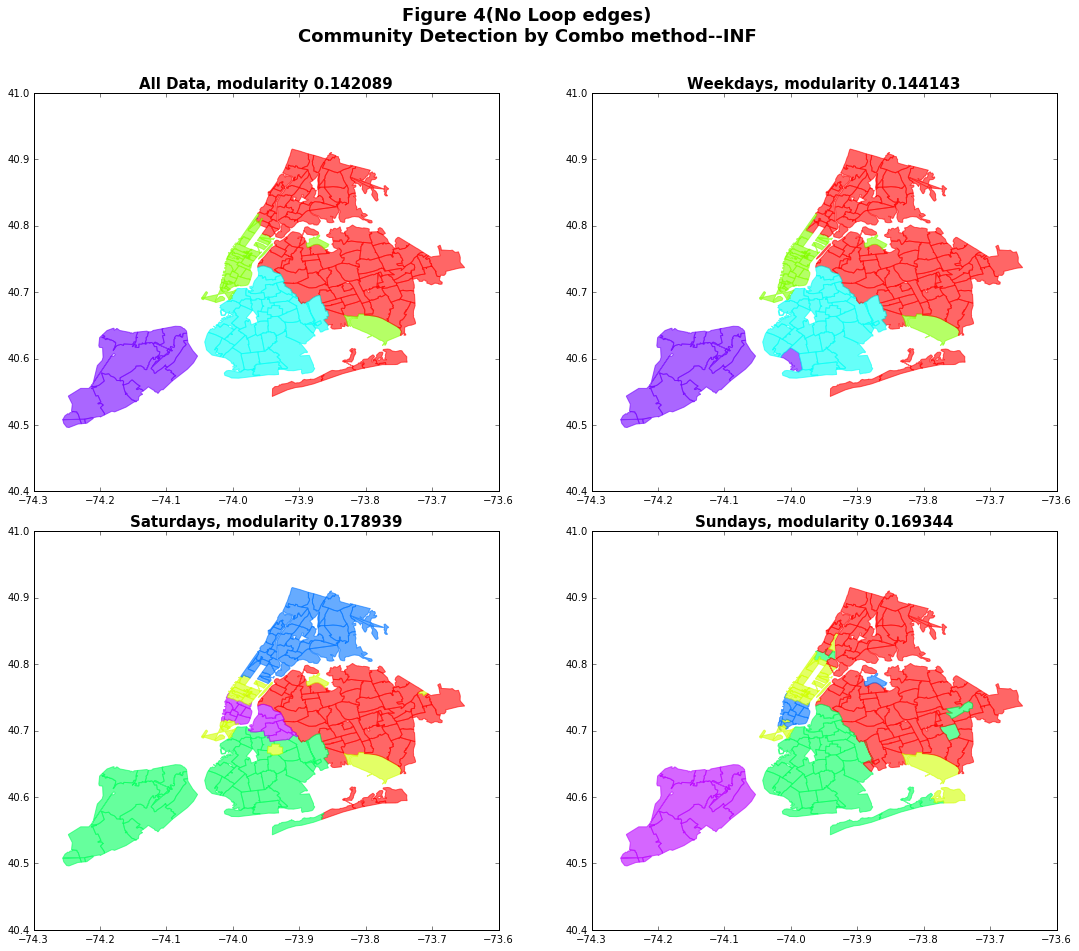

In [22]:
fig4 = plt.figure(num = 4, figsize = (20,15))
plt.suptitle('Figure 4(No Loop edges)\nCommunity Detection by Combo method--INF', fontweight="bold", size=18)
for i in range(4):
    CommPartShape(fig4, NLGraph2[i], NLCPInf[i],i)

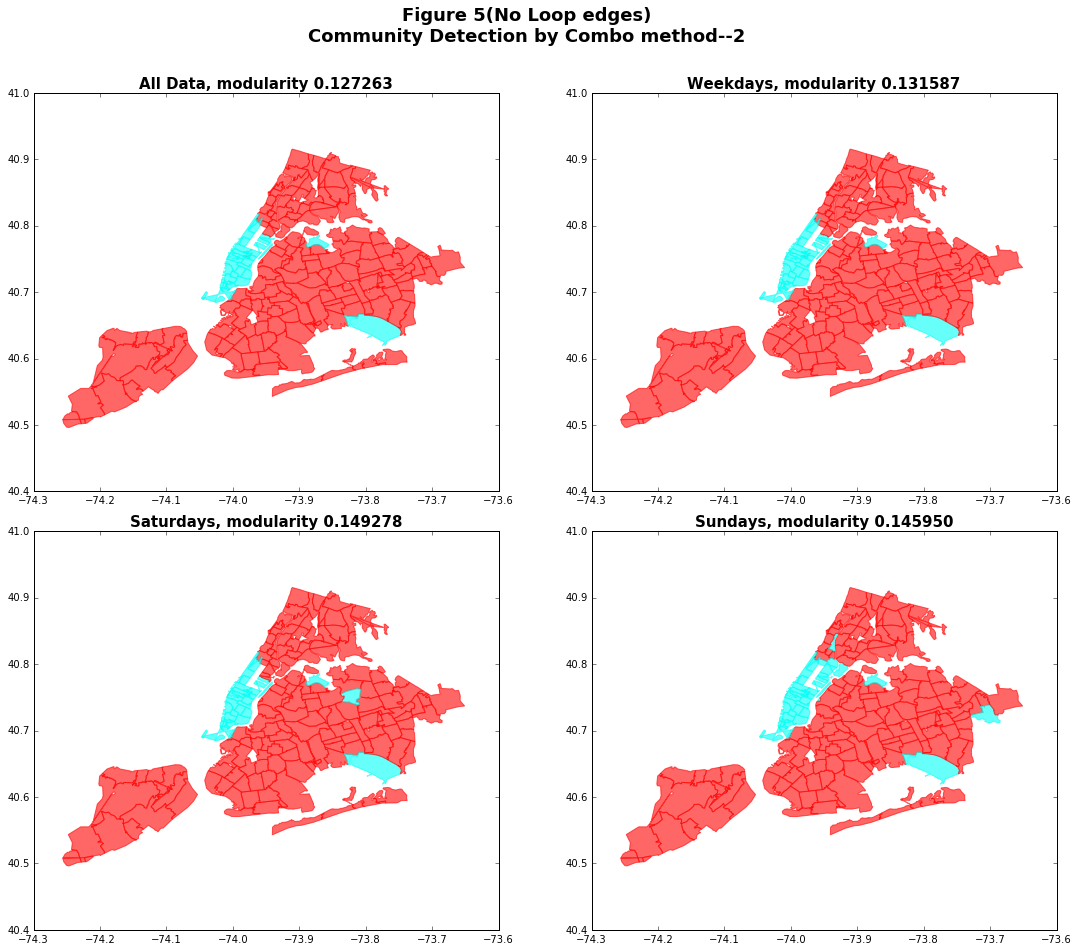

In [23]:
fig5 = plt.figure(num = 5, figsize = (20,15))
plt.suptitle('Figure 5(No Loop edges)\nCommunity Detection by Combo method--2', fontweight="bold", size=18)
for i in range(4):
    CommPartShape(fig5, NLGraph2[i], NLCP2[i],i)

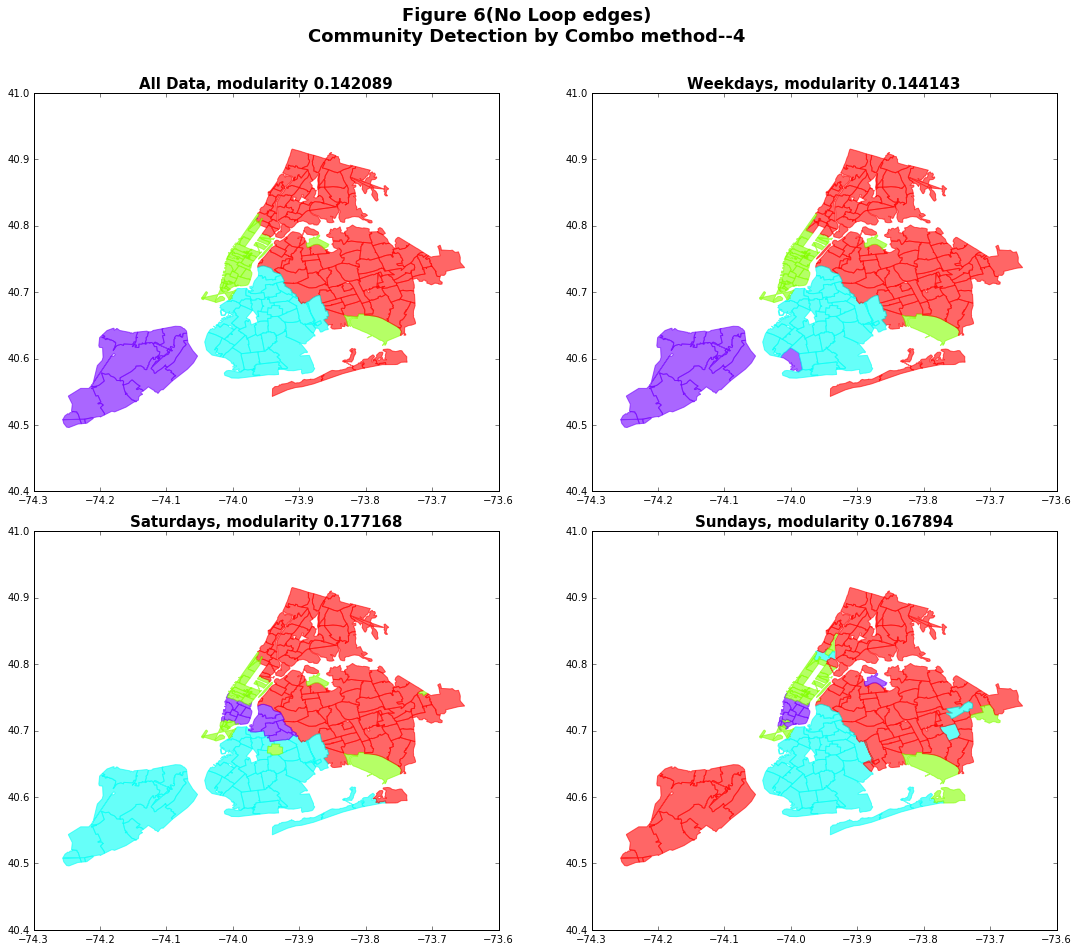

In [24]:
fig6 = plt.figure(num = 6, figsize = (20,15))
plt.suptitle('Figure 6(No Loop edges)\nCommunity Detection by Combo method--4', fontweight="bold", size=18)
for i in range(4):
    CommPartShape(fig6, NLGraph2[i], NLCP4[i],i)

### Those observation suggested us to proceed with the partition Combo INF, also with the graphs having loop edges

### Step 4, some data visualization and demonstration

#### A) General glance, twitter users' daily activities, with weekends highlighted

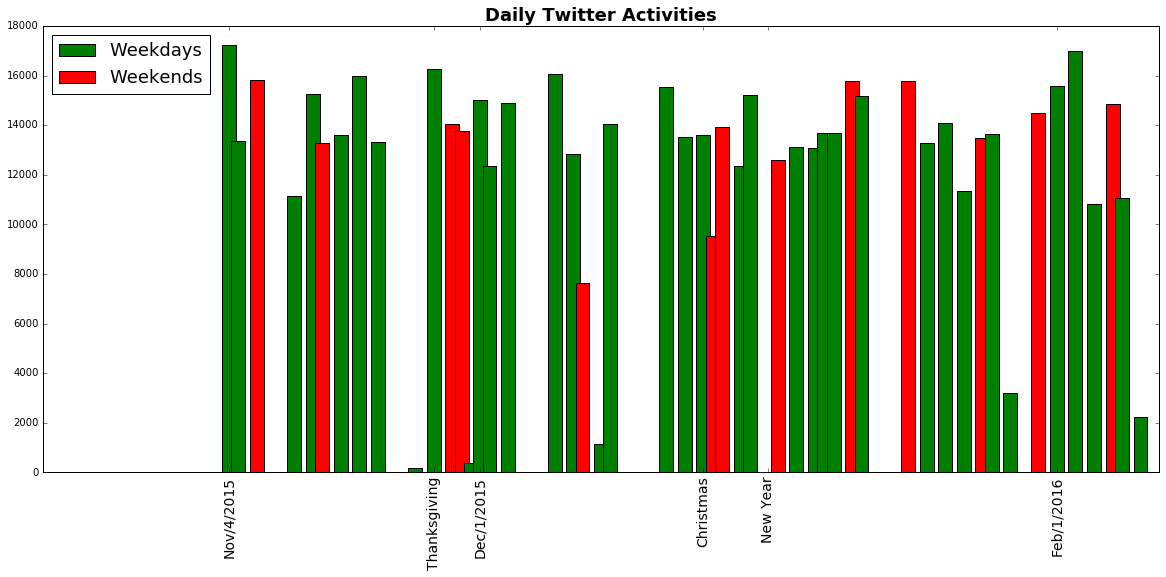

In [68]:
start_date = datetime.fromtimestamp(time.mktime(TimeList[0][0])).date()
end_date = datetime.fromtimestamp(time.mktime(TimeList[0][-1])).date()
day_count = (end_date-start_date).days
DateList = [start_date + timedelta(n) for n in range(day_count)]
T_ACT = {i:0 for i in DateList}
for single_day in DateList:
    day_list = [x for x in Data[0].DateTime if datetime.fromtimestamp(time.mktime(x)).date() == single_day]
    T_ACT[single_day] = len(day_list)
Thanksgiving = date(2015, 11, 26)
Christmas = date(2015, 12, 25)
NewYear = date(2016, 1, 1)
a = Thanksgiving - start_date
b = date(2015,12,1) - start_date
c = Christmas - start_date
d = NewYear - start_date
e = date(2016,2,1) - start_date
fig7 = plt.figure(num = 7, figsize=(20,8))
ax = fig7.add_subplot(1,1,1)
ax.set_title("Daily Twitter Activities", fontweight="bold", size=18)
bar = ax.bar(range(day_count), T_ACT.values(), color = ['g','g','g','r','r','g','g'] , align='center', width = 1.5)
ax.legend((bar[0],bar[4]), ('Weekdays', 'Weekends'), loc = 2, prop={'size':18})
ax.set_xticks([0,a.days, b.days, c.days, d.days, e.days])
ax.set_xticklabels(['Nov/4/2015','Thanksgiving','Dec/1/2015','Christmas','New Year','Feb/1/2016'],\
                       rotation=90, fontsize = 14)

#### B) Top places (zip codes) with highest amount of tweets, marked in map

In [27]:
def TopZipCode(fig, date_index, top = 10):
    ziplist = sort(Data[date_index].ZipCode.unique())
    percentage_ziplist = {i:0 for i in ziplist}
    T = len(Data[date_index])
    for i in ziplist:
        percentage_ziplist[i] = 100.0 * len(Data[date_index][Data[date_index].ZipCode == i])/T
    sorted_ziplist = sorted(percentage_ziplist.items(), key=operator.itemgetter(1), reverse = 1)
    new_ziplist = [x[0] for x in sorted_ziplist]
    percentage = [x[1] for x in sorted_ziplist]
    
    title = ['All days','Weekdays', 'Saturdays', 'Sundays']
    ax = fig.add_subplot(221 + date_index)
    plt.title(title[date_index], fontweight="bold", size=15)
    ax.bar(range(top), percentage[:top], color='g')
    ax.set_xticks(range(top))
    ax.set_xticklabels(new_ziplist[:top], fontsize = 13-top/4, fontweight="bold", rotation = 30)
    plt.subplots_adjust(hspace = 0.2, wspace = 0.1)
    return new_ziplist[:top]

### You can change the number of "top" as you want to see the difference

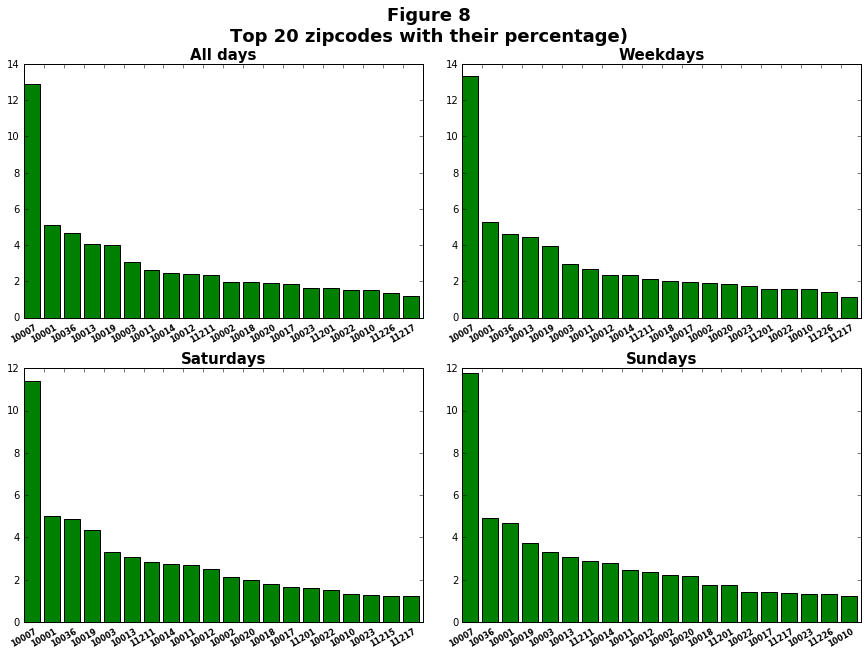

In [69]:
top = 20

TopZip = range(4)
fig8 = plt.figure(num = 8, figsize = (15,10))
plt.suptitle('Figure 8\nTop %d zipcodes with their percentage)'%top, fontweight="bold", size=18)
for i in range(4):
    TopZip[i] = TopZipCode(fig8, i, top)

In [70]:
def HighlightTopMap(fig, G, partition, date_index):
    '''This functin is for plotting geographical maps with 4 arguments:
    fig: for subplotting purpose mainly, usually not necessary
    G: the graph, does not have to be directed, for modularity computation
    partitin: self-explanatory, although it can be non-integers
    data_index: 0 denoting all data, and 1, 2, 3 for weekday, Saturday, Sunday
    '''
    if max([a-int(a) for a in partition.values()])==0:
        cmap = matplotlib.cm.hsv(np.linspace(0,1,max(partition.values())+2))
        mode = 1
    else:
        cmap = matplotlib.cm.cool(np.linspace(0,1,128))
        mode = 2
        v2 = log(max(partition.values()))
        v1 = log(min(partition.values()))
    title = ['All Data','Weekdays', 'Saturdays', 'Sundays']
    
    ClusterList = [ (j, partition.values().count(j)*1.0/len(partition)) for j in set(partition.values())]
    ClusterList.sort(key = operator.itemgetter(1), reverse = 1)
    ClusterRanking = [i[0] for i in ClusterList]
    
    ax = fig.add_subplot(221 + date_index)
    plt.title(title[date_index]+', modularity %f' % modularity(G,partition), fontweight="bold", size=15)
    for s in range(lzipsf):
        z = int(zipsf_records[s][1][-5:])
        if z in partition.keys():
            k = partition[z]
            if mode == 2:
                k = int((log(k)-v1)/(v2-v1)*127.9999)
            shape = zipsf_shape[s]
            w = [(i[0],i[1]) for i in shape.shape.points]
            poly = Polygon(w)
            if z in TopZip[date_index]:
                ax.add_patch(PolygonPatch(poly, fc = 'k', ec = 'k', alpha = 0.9, zorder = 2))
            else:
                c = cmap[ClusterRanking.index(k)][0:3]
                ax.add_patch(PolygonPatch(poly, fc = c, ec = c, alpha = 0.6, zorder = 2))
    ax.axis('scaled')
    ax.legend()
    plt.subplots_adjust(hspace = 0.1, wspace = 0)

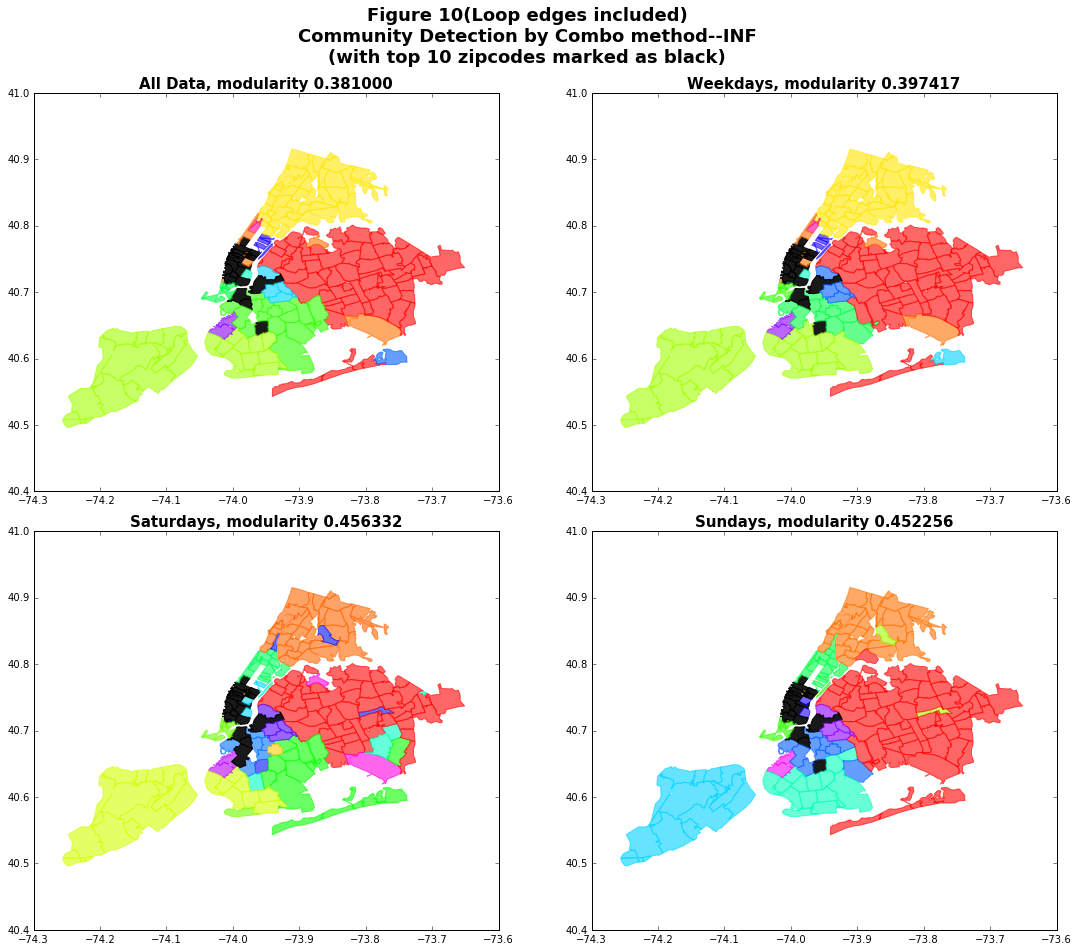

In [71]:
fig10 = plt.figure(num = 10, figsize = (20,15))
plt.suptitle('Figure 10(Loop edges included)\nCommunity Detection by Combo method--INF\n'+\
             '(with top 10 zipcodes marked as black)',fontweight="bold", size=18)
for i in range(4):
    HighlightTopMap(fig10, Graph2[i], CPInf[i],i)

#### C) Some demographic data of New York gathered in 2014

In [31]:
Demographic=pd.read_csv("/Users/CQ/Documents/Project1/Demographic_2014.csv", low_memory=False)
variable_names=list(Demographic.iloc[0,:])
#first row is variable name
Demographic=Demographic.iloc[1:,:]
Demographic.index=range(len(Demographic))
#get zipcode from the strange string
zipcode=pd.DataFrame([int(Demographic.loc[i,'Name of Area'].split(" ")[0]) for i in range(len(Demographic))])
Demographic.columns=variable_names
Demographic=pd.concat((zipcode,Demographic),axis=1)
Demographic=Demographic.rename(columns={0:'zipcode'})

* Slice and simplify the dataframe according to our zipcode database so we can focus on New York instead of the whole country

In [95]:
Demo_NY = Demographic[Demographic.zipcode.isin(Data[0].ZipCode.unique())]

In [96]:
#Features we may need to use from census. 
population=['SE_T001_001','SE_T009_002','SE_T009_003','SE_T009_004','SE_T009_005']
#Total population, #Total Population under 18; 18-34; 35-64;65+#

race=['SE_T013_001','SE_T013_002','SE_T013_003','SE_T013_004','SE_T013_005','SE_T013_006','SE_T013_007','SE_T013_008']
#Total,White Along, Black or African American, American Indian and Alaska Native Alone, Asian Alone, 
#Native Hawaiian and Other Pacific Islander Alone,Some Other Race Alone,Two or More races

marriage=['SE_T017_001','SE_T017_002','SE_T017_003','SE_T017_004','SE_T017_007','SE_T018_002']
# Households, Family households, Married-couple Family, Single-parent family, Nofamily Households, Household with one or more people under 18

education=['SE_T025_001','SE_T025_002','SE_T025_003','SE_T025_004','SE_T025_005','SE_T025_006','SE_T025_007','SE_T025_008']
# Population over 25: less than high school, high school, some college, Bechelor, Master, Professional school, Doctorate

employment=['SE_T037_001','SE_T037_002','SET037_003']
#Civilian Population In Labor Force 16 Years And Over: employed; unemployed.

income=['SE_T056_001','SE_T056_002','SE_T056_003','SE_T056_004','SE_T056_005','SE_T056_006','SE_T056_007',
       'SE_T056_008','SE_T056_009','SE_T056_010','SE_T056_011','SE_T056_012','SE_T056_013'
       'SE_T056_014','SE_T056_015','SE_T056_016','SE_T056_017',]
#Households, Households: Less than $10,000;Households: $10,000 to $14,999;Households: $15,000 to $19,999
#$20,000 to $24,999;Households: $25,000 to $29,999;Households: $30,000 to $34,999;Households: $35,000 to $39,999
 #Households: $40,000 to $44,999; Households: $45,000 to $49,999;Households: $50,000 to $59,999
# Households: $60,000 to $74,999 ;Households: $75,000 to $99,999 ; Households: $100,000 to $124,999
#$125,000 to $149,999; $150,000 to $199,999 ;$200,000 or More

income_per_capital=['SE_T083_001']
#Per capita income (In 2014 Inflation adjusted dollars)

insurance=['SE_T145_001','SE_T145_002','SE_T145_003','SE_T145_004','SE_T145_005']
# Total; No Health Insurance Coverage;With Health Insurance Coverage;
#With Health Insurance Coverage: Public Health Coverage;With Health Insurance Coverage: Private Health Insurance

born_place=['SE_T133_001','SE_T133_002','SE_T133_003','SE_T133_004','SE_T133_005']
#Total; Total Population:Native Born;Foreign Born
#Total Population: Foreign Born: Naturalized Citizen; Not a Citizen

transportation_to_work=['SE_T128_001','SE_T128_002','SE_T128_003','SE_T128_004','SE_T128_005','SE_T128_006','SE_T128_007','SE_T128_008']
#Workers 16 Years and over:
#Workers 16 Years and over: Car, truck, or van;Drove Alone;Carpooled;Public transportation (Includes Taxicab)
#Motorcycle;Bicycle;Walked;Other means; Worked at home

time_on_road_towork=['SE_T129_001','SE_T129_002','SE_T129_003','SE_T129_004','SE_T129_005',
                     'SE_T129_006','SE_T129_007','SE_T129_008','SE_T129_009','SE_T129_010']
# Workers 16 Years and over:
#Workers 16 Years and over: Did not work at home;Less than 10 minutes;10 to 19 minutes;20 to 29 minutes
#30 to 39 minutes;40 to 59 minutes;60 to 89 minutes;90 or More minutes
#Worked at home

type_house=['SE_T095_003','SE_T094_001','SE_T094_002','SE_T094_003']
#Vacant houses; Occupied houses; Owner Occupied; Renter Occupied

House_price_owner=['SE_T100_001','SE_T100_002','SE_T100_003''SE_T100_004','SE_T100_005',
                  'SE_T100_006','SE_T100_007','SE_T100_008','SE_T100_009','SE_T100_010']
#Owner-occupied housing units:Less than $20,000;$20,000 to $49,999;$50,000 to $99,999;$100,000 to $149,999
#$150,000 to $299,999;300,000 to $499,999;500,000 to $749,999;750,000 to $999,999;1,000,000 or More

Rent_price=['SE_T102_001','SE_T102_002','SE_T102_003','SE_T102_004','SE_T102_005',
            'SE_T102_006','SE_T102_007','SE_T102_008','SE_T102_009']

#Renter-occupied housing units with cash rent: Less than $300; $300 to $599;$600 to $799;$800 to $999
#$1,000 to $1,249;$1,250 to $1,499;$1,500 to $1,999; $2,000 or More


veteran=['SE_T131_001','SE_T131_002','SE_T131_003','SE_T131_004','SE_T131_005','SE_T131_006','SE_T131_007']
#Civilian Population 18 Years and over:
#Civilian Population 18 Years and over: Veteran;Veteran: 18 to 64 Years; 65 Years and over
#Civilian Population 18 Years and over: Nonveteran; Nonveteran: 18 to 64 Years; 65 Years and over

other=['SE_T142_001','SE_T157_001']
#Owner-ocupied units; Gini index

#zipcode:10020, ..., we have two zipcodes where nobody lives. (population=0)